<a href="https://colab.research.google.com/github/xAn-x/VisionLab/blob/master/ResNet_34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [205]:
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size,stride,**kwargs):
    super().__init__()
    padding=kernel_size//2 if "padding" not in kwargs else kwargs["padding"]
    self.block=nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

  def forward(self,x):
    return self.block(x)



class ResidualBlock(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size,stride):
    super().__init__()
    self.conv1=ConvBlock(in_channels,out_channels,kernel_size,stride)
    self.conv2=ConvBlock(out_channels,out_channels,kernel_size,1)
    self.downsample=None
    if stride!=1:
      self.downsample=ConvBlock(in_channels,out_channels,1,stride)

  def forward(self,x):
    out=self.conv1(x)
    out=self.conv2(out)
    if self.downsample is not None:
      x=self.downsample(x)
    return out+x


class Resnet34(nn.Module):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    self.conv1=ConvBlock(in_channels,64,7,2,padding=3)
    self.max_pool=nn.MaxPool2d(3,2,padding=1)

    self.conv2_x=Resnet34.create_res_stack(64,64,3,1,1) # orignal-num_layer: 3
    self.conv3_x=Resnet34.create_res_stack(64,128,3,2,1) # orignal-num_layer: 6
    self.conv4_x=Resnet34.create_res_stack(128,256,3,2,1) # orignal-num_layer: 4
    # self.conv5_x=Resnet34.create_res_stack(256,512,3,2,1) # orignal-num_layer: 3

    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc=nn.Linear(256,num_classes)

  def forward(self,x):
    x=self.conv1(x)
    x=self.max_pool(x)

    x=self.conv2_x(x)
    x=self.conv3_x(x)
    x=self.conv4_x(x)
    # x=self.conv5_x(x)

    x=self.avg_pool(x)
    x=torch.flatten(x, 1)
    x=self.fc(x)

    return x

  @staticmethod
  def create_res_stack(in_channels,out_channels,kernel_size,stride,num_layers):
    blocks=[]
    blocks.append(ResidualBlock(in_channels,out_channels,kernel_size,stride))
    for _ in range(1,num_layers):
      blocks.append(ResidualBlock(out_channels,out_channels,kernel_size,1))
    return nn.Sequential(*blocks)

In [206]:
resnet=Resnet34(3,10)

resnet

Resnet34(
  (conv1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2_x): Sequential(
    (0): ResidualBlock(
      (conv1): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv2): ConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
    

In [207]:
sum((torch.numel(p) for p in resnet.parameters()))

1235274

In [208]:
x=torch.rand((1,3,224,224))
resnet(x).shape

torch.Size([1, 10])

In [209]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader

In [210]:
tfms=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0,),std=(1,))
])

In [211]:
train_ds=CIFAR10(root=".",train=True,transform=tfms,download=True)
val_ds=CIFAR10(root=".",train=False,transform=tfms,download=True)

print(len(train_ds),len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
50000 10000


In [212]:
classes=train_ds.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [213]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=128,shuffle=True,num_workers=2,pin_memory=True)

print(len(train_dl),len(val_dl))

782 79


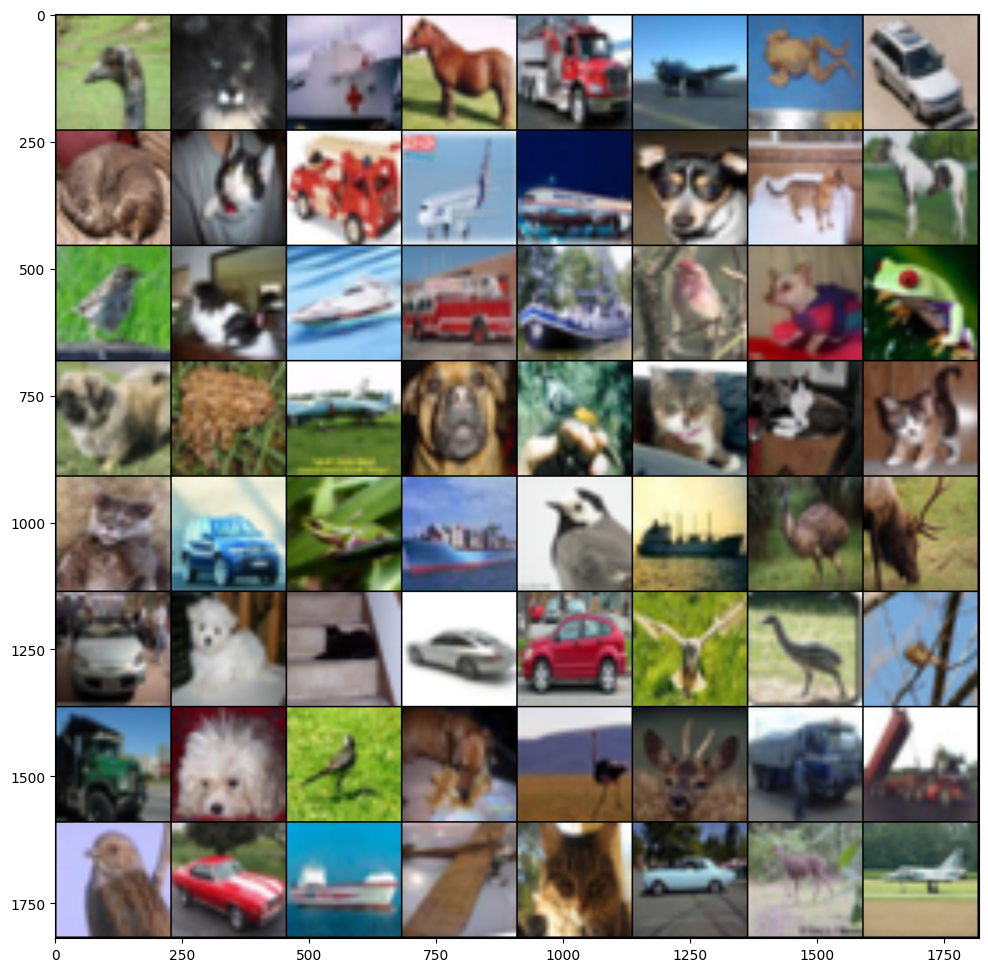

In [214]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images,labels in train_dl:
  grid=make_grid(images,nrow=8,padding=3)
  plt.figure(figsize=(12,12))
  plt.imshow(grid.permute(1,2,0).numpy())
  break

In [215]:
EPOCHS=3
learning_rate=3e-4
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
log_every_kth_epoch=1
eval_interval=100
optimizer=torch.optim.AdamW(resnet.parameters(),lr=learning_rate)

from sklearn.metrics import accuracy_score
device

device(type='cuda')

In [216]:
def evaluate(history):
  for split in ["train","val"]:
    loss=history[f"{split}_loss"][-eval_interval:]
    acc=history[f"{split}_acc"][-eval_interval:]

    loss=torch.tensor(loss)
    acc=torch.tensor(acc)
    print(f"{split}_loss:{loss.mean().item():.3f},{split}_acc:{acc.mean().item():.3f}")


In [217]:
def train():
  history={"train_loss":[],"val_loss":[],"train_acc":[],"val_acc":[]}
  resnet.to(device)

  for epoch in range(EPOCHS):
    resnet.train()
    for images,labels in train_dl:
      images,labels=images.to(device),labels.to(device)
      # print(images.shape,labels.shape)
      logits=resnet(images)
      loss=F.cross_entropy(logits,labels)
      probs=F.softmax(logits,dim=-1)
      y_hat=torch.argmax(probs,dim=-1)
      acc=accuracy_score(y_hat.detach().cpu().numpy(),labels.detach().cpu().numpy())

      history["train_loss"].append(loss.item())
      history["train_acc"].append(acc.item())

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    resnet.eval()
    for images,labels in val_dl:
      images,labels=images.to(device),labels.to(device)
      with torch.no_grad():
        logits=resnet(images)
        loss=F.cross_entropy(logits,labels)

        probs=F.softmax(logits,dim=-1)
        y_hat=torch.argmax(probs,dim=-1)
        acc=accuracy_score(y_hat.detach().cpu().numpy(),labels.detach().cpu().numpy())

      history["val_loss"].append(loss.item())
      history["val_acc"].append(acc.item())

    if (epoch+1)%log_every_kth_epoch==0:
      print(f"{epoch+1}/{EPOCHS}:")
      evaluate(history)
      print()

  return history

In [218]:
history=train()

1/3:
train_loss:1.200,train_acc:0.573
val_loss:1.541,val_acc:0.455

2/3:
train_loss:1.015,train_acc:0.643
val_loss:1.769,val_acc:0.422

3/3:
train_loss:0.890,train_acc:0.685
val_loss:1.268,val_acc:0.564



In [223]:
len(history["train_loss"])

2346

Text(0.5, 1.0, 'val_acc')

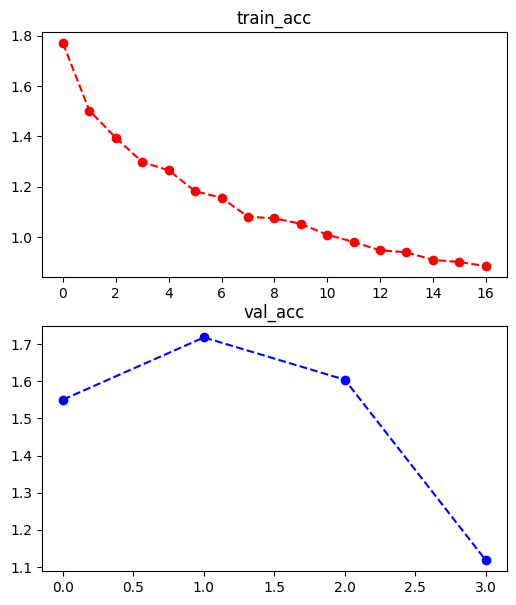

In [258]:
train_losses=torch.tensor(history["train_loss"]).view(-1,138)
val_losses=torch.tensor(history["val_loss"][:-1]).view(-1,59)



fig, ax = plt.subplots(2,figsize=(6,7))
# Plot the training loss
ax[0].plot(train_losses.mean(-1), "o--",color="red")
ax[0].set_title("train_acc")

# Plot the validation loss
ax[1].plot(val_losses.mean(-1), "o--", color='blue', label='Validation Loss')
ax[1].set_title("val_acc")

Text(0.5, 1.0, 'val_acc')

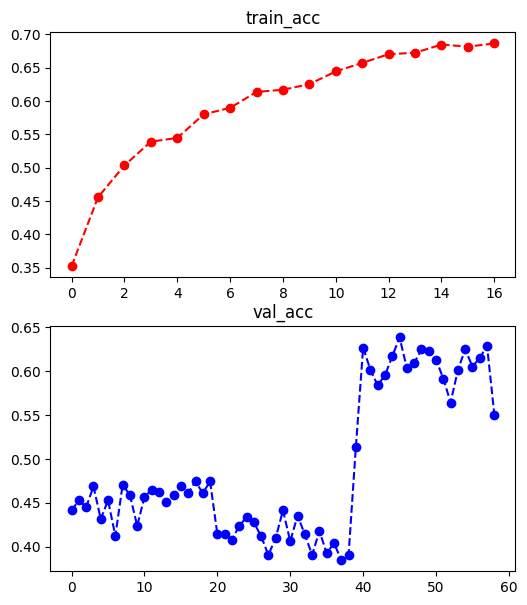

In [257]:
train_acc=torch.tensor(history["train_acc"]).view(-1,138)
val_acc=torch.tensor(history["val_acc"][:-1]).view(-1,4)

fig, ax = plt.subplots(2,figsize=(6,7))
# Plot the training loss
ax[0].plot(train_acc.mean(-1), "o--",color="red")
ax[0].set_title("train_acc")

# Plot the validation loss
ax[1].plot(val_acc.mean(-1), "o--", color='blue', label='Validation Loss')
ax[1].set_title("val_acc")


In [242]:
 # The network i
 # This is just a test u can run it for longer to extract more performance,as in collab it is taking a lot of time